In [1]:
#IMPORTAZIONE DELLE LIBRERIE
import pandas as pd #PER STRUTTURE DATI E MANIPOLAZIONE (DF/SERIES)
import seaborn as sns #PER PLOT
import matplotlib.pyplot as plt #PER PLOT


In [2]:
#CREAZIONE DEL DATASET E VISUALIZZAZIONE DI DIMENSIONI
#VISUALIZZAZIONI TIPI DI DATO DELLE COLONNE
df = pd.read_csv('insurance.csv')
print(df.shape)
print(df.dtypes)

(381109, 12)
id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object


In [3]:
# PRE-PROCESSING
# CONVERSIONE DI "GENDER" IN BINARIO (MALE), RIMOZIONE DELL'ID DEL RECORD
# CONVERSIONE DI VEHICLE_AGE IN NUMERICO E VEHICLE_DAMAGE IN BINARIO
df = df.rename(columns={"Gender": "Male"})
df = df.drop(['id'], axis=1)
cleanup_nums = {"Vehicle_Age": {"< 1 Year": -1, "1-2 Year": 0, "> 2 Years": 1},
                "Vehicle_Damage": {"Yes": 1, "No": 0},
                "Male": {"Male": 1, "Female": 0}} #DIZIONARIO CONTENENTE
                                                  #REGOLE DI CONVERSIONE
df = df.replace(cleanup_nums)

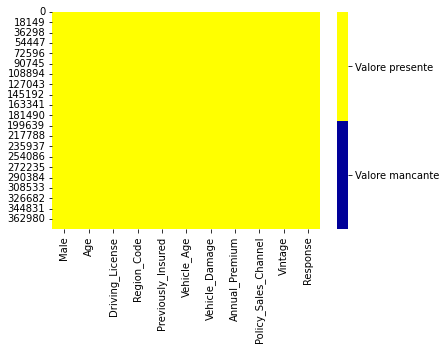

In [4]:
# HEATMAP DEI VALORI MANCANTI
cols = df.columns[:12]  # first 30 columns
colours = ['#000099', '#ffff00']  # specify the colours - yellow is missing. blue is not missing.
ax = sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.05, 0.05])
colorbar.set_ticklabels(['Valore mancante', 'Valore presente'])
plt.show()

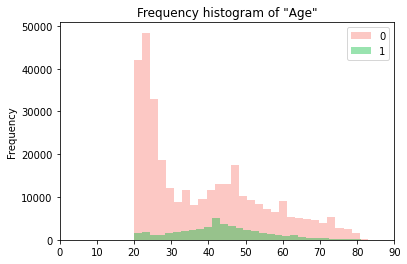

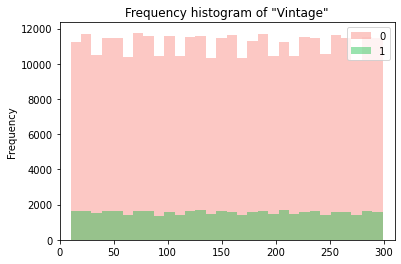

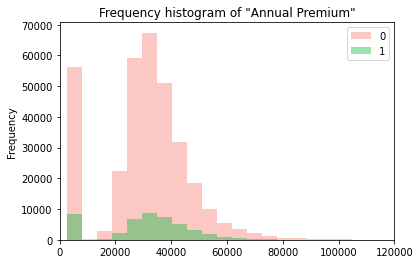

In [5]:
# DISTRIBUZIONE DELLE FREQUENZE SU VARIABILI VARIE

#DISTRIBUZIONE SU "AGE"
kwargs = dict(alpha=0.4, bins=30) #TRASPARENZA E BINNING

x1 = df.loc[df.Response == 1, 'Age']
x2 = df.loc[df.Response == 0, 'Age']
plt.hist(x2, **kwargs, color='#F8766D', label='0')
plt.hist(x1, **kwargs, color='#00BA38', label='1')
plt.gca().set(title='Frequency histogram of "Age"', ylabel='Frequency')
plt.xlim(0, 90)
plt.legend()
plt.show()

#DISTRIBUZIONE SU "VINTAGE"
x1 = df.loc[df.Response == 1, 'Vintage']
x2 = df.loc[df.Response == 0, 'Vintage']
plt.hist(x2, **kwargs, color='#F8766D', label='0')
plt.hist(x1, **kwargs, color='#00BA38', label='1')
plt.gca().set(title='Frequency histogram of "Vintage"', ylabel='Frequency')
plt.xlim(0, 310)
plt.legend();
plt.show()

#DISTRIBUZIONE SU "ANNUAL_PREMIUM"
kwargs = dict(alpha=0.4, bins=100)

x1 = df.loc[df.Response == 1, 'Annual_Premium']
x2 = df.loc[df.Response == 0, 'Annual_Premium']
plt.hist(x2, **kwargs, color='#F8766D', label='0')
plt.hist(x1, **kwargs, color='#00BA38', label='1')
plt.gca().set(title='Frequency histogram of "Annual Premium"', ylabel='Frequency')
plt.xlim(0, 120000)
plt.legend()
plt.show()


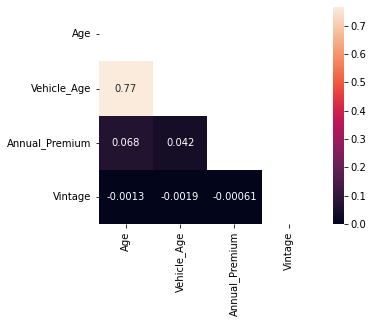

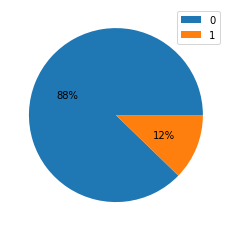

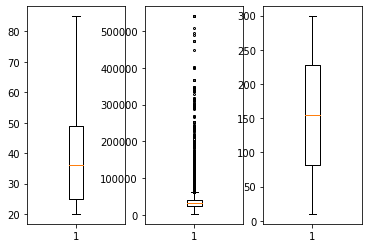

In [6]:
#MATRICE DI CORRELAZIONE
import numpy as np #PER TRIANGOLIZZAZIONE MATRICE DI CORRELAZIONE
corMatrix = df[['Age', 'Vehicle_Age', 'Annual_Premium', 'Vintage']].corr()
Matrix = np.triu(corMatrix)
sns.heatmap(corMatrix, annot=True, square=True, mask = Matrix)
plt.show()

#GRAFICO A TORTA CHE DIMOSTRA LO SBILANCIAMENTO
freq = df['Response'].value_counts(normalize=True) * 100
plt.pie(freq, autopct='%.0f%%')
plt.legend(['0', '1'])
plt.show()

#BOXPLOT DI AGE, ANNUAL_PREMIUM E VINTAGE
plt.subplot(1, 3, 1)
plt.boxplot(df[['Age']], flierprops={'marker': 'o', 'markersize': 2})
plt.subplot(1, 3, 2)
plt.boxplot(df[['Annual_Premium']], flierprops={'markersize': 2})
plt.subplot(1, 3, 3)
plt.boxplot(df[['Vintage']], flierprops={'markersize': 2})
plt.show()

In [7]:
#SPLIT STRATIFICATO TEST/TRAIN
from sklearn import model_selection

y = df['Response']
x = df.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)

In [8]:
#FUNZIONE PER GENERAZIONE DI MATRICE DI CONFUSIONE E RESTITUZIONE DI PARAMETRI
#INTERESSANTI
def confusionMatrix (Prediction, Ground_Truth, verbose = False):
    from sklearn.metrics import confusion_matrix as cm
    CM = cm(Ground_Truth, Prediction)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    accuracy = (TP+TN)/(TP + FN + FP + TN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    if (verbose):
        print("Accuracy:      %f\n" %(accuracy))
        print("Sensitivity:   %f\n" %(sensitivity))
        print("Specificity:   %f\n" %(specificity))
    return (accuracy, sensitivity, specificity)

In [63]:
from sklearn.tree import DecisionTreeClassifier

#FUNZIONE PER LA CREAZIONE E IL TESTING DI ALBERI
def tree_test(X_train, y_train, X_test, y_test, verbose = True):
    dtree = DecisionTreeClassifier(random_state=1)
    dtree = dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    confusionMatrix(pred, y_test, verbose)
    return (dtree)

In [64]:
#FUNZIONE PER SALVATAGGIO DI 'fpr' E 'tpr' A PARTIRE DA MODELLO
def f_t_pr(model, X_test, y_test):
    from sklearn.metrics import roc_curve
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return (fpr, tpr)

In [65]:
#CREZIONE DI DATASET SENZA VARIABILI CATEGORICHE (PER ALBERO)
X_train_num = X_train.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
X_test_num = X_test.drop(['Region_Code', 'Policy_Sales_Channel'], axis=1)
dtree = tree_test(X_train_num, y_train, X_test_num, y_test)

Accuracy:      0.823323

Sensitivity:   0.286377

Specificity:   0.898325



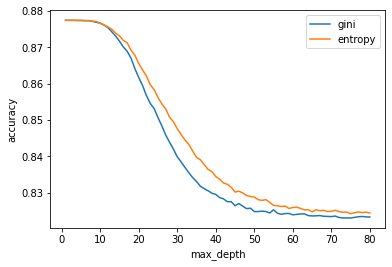

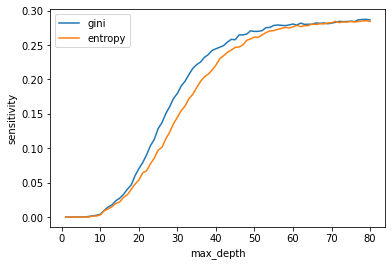

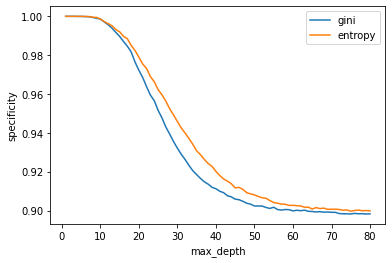

In [66]:
#VOGLIAMO VISUALIZZARE L'IMPATTO DELLA PROFONDITA' E DEL CRITERIO DI SPLIT
# SULLA QUALITA DELL'ALBERO (VERIFICARE RISCHIO OVERFITTING)
max = dtree.get_depth()
max_depth = []
acc_gini = []
acc_entropy = []
sens_gini = []
spec_gini = []
sens_entropy = []
spec_entropy = []
for i in range(1,max):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=1)
 dtree.fit(X_train_num, y_train)
 pred = dtree.predict(X_test_num)
 acc_gini.append(confusionMatrix(pred, y_test)[0])
 sens_gini.append(confusionMatrix(pred, y_test)[1])
 spec_gini.append(confusionMatrix(pred, y_test)[2])
 ####
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=1)
 dtree.fit(X_train_num, y_train)
 pred = dtree.predict(X_test_num)
 acc_entropy.append(confusionMatrix(pred, y_test)[0])
 sens_entropy.append(confusionMatrix(pred, y_test)[1])
 spec_entropy.append(confusionMatrix(pred, y_test)[2])
 ####
 max_depth.append(i)

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                  'sens_gini': pd.Series(sens_gini),
                  'spec_gini': pd.Series(spec_gini),
                  'acc_entropy':pd.Series(acc_entropy),
                  'sens_entropy':pd.Series(sens_entropy),
                  'spec_entropy':pd.Series(spec_entropy),
                  'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot('max_depth','sens_gini', data=d, label='gini')
plt.plot('max_depth','sens_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('sensitivity')
plt.legend()
plt.show()

plt.plot('max_depth','spec_gini', data=d, label='gini')
plt.plot('max_depth','spec_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('specificity')
plt.legend()
plt.show()

In [37]:
#RIBILANCIAMENTO CON UNDERSAMPLING CASUALE
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy={0:y_train.value_counts()[1], 1:(int(y_train.value_counts()[1]*0.7))})
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(y_train_under.value_counts())

#RIBILANCIAMENTO CON SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print(y_train_over.value_counts())

# SMOTE + RANDOM UNDERSAMPLING
#The original paper on SMOTE suggested combining SMOTE
# with random undersampling of the majority class.
oversample = SMOTE(sampling_strategy=0.3) #porto lo sbilanicamento al 30%
under = RandomUnderSampler(sampling_strategy=0.7)
X_train_mix, y_train_mix = oversample.fit_resample(X_train, y_train)
X_train_mix, y_train_mix = under.fit_resample(X_train_mix, y_train_mix)
print(y_train_mix.value_counts())


0    32697
1    22887
Name: Response, dtype: int64
1    234079
0    234079
Name: Response, dtype: int64
0    100318
1     70223
Name: Response, dtype: int64


In [43]:
#ALTRI ALBERI (CON DATASET VARI)

#ALBERO CON UNDERSAMPLING CASUALE
X_train_under_num = X_train_under.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_us = tree_test(X_train_under_num, y_train_under, X_test_num, y_test)

Accuracy:      0.732938

Sensitivity:   0.623278

Specificity:   0.748256



In [44]:
#ALBERO CON SMOTE
X_train_over_num = X_train_over.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_os = tree_test(X_train_over_num, y_train_over, X_test_num, y_test)

Accuracy:      0.767871

Sensitivity:   0.529865

Specificity:   0.801116



In [45]:
#ARBERO CON SMOTE + UNDERSAMPLING RANDOM
X_train_mix_num = X_train_mix.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_mix = tree_test(X_train_mix_num, y_train_mix, X_test_num, y_test)

Accuracy:      0.755337

Sensitivity:   0.571255

Specificity:   0.781051



In [57]:
#FUNZIONE PER STAMPA DELLE CURVE ROC
def plot_roc(*args, X_test, y_test, labels=[]):
    i = 0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for model in args:
        fpr, tpr = f_t_pr(model, X_test, y_test)
        plt.plot(fpr, tpr, color=colors[i], label=labels[i])
        i+=1
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
#STAMPA DELLE CURVE ROC
lab = ['Original Data', 'Random Undersampling', 'SMOTE', 'SMOTE + Random Undersampling']
plot_roc(dtree, dtree_us, dtree_os, dtree_mix, X_test = X_test_num, y_test = y_test, labels=lab)

In [52]:
#NAIVE BAYES SBILANCIATO
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.820323

Sensitivity:   0.363020

Specificity:   0.884201



(0.8203230913209659, 0.3630200528081068, 0.8842005582137161)

In [53]:
#NAIVE BAYES UNDERSAMPLING CASUALE
gnb = GaussianNB()
gnb_us = gnb.fit(X_train_under, y_train_under)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.701477

Sensitivity:   0.848284

Specificity:   0.680971



(0.7014772637821102, 0.8482837365303647, 0.6809708931419458)

In [54]:
#NAIVE BAYES SMOTE

gnb = GaussianNB()
gnb_os = gnb.fit(X_train_over, y_train_over)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.692329

Sensitivity:   0.863270

Specificity:   0.668451



(0.6923285490628253, 0.8632698208806109, 0.668450956937799)

In [55]:
#NAIVE BAYES MIX

gnb = GaussianNB()
gnb_mix = gnb.fit(X_train_mix, y_train_mix)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.707154

Sensitivity:   0.839363

Specificity:   0.688686



(0.7071536651710355, 0.8393634482266467, 0.6886862041467304)

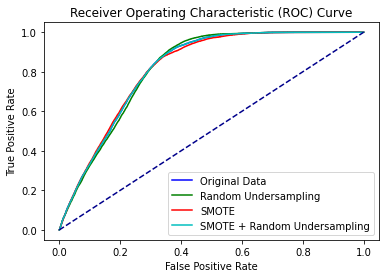

In [61]:
#STAMPA DELLE CURVE ROC
plot_roc(gnb, gnb_us, gnb_os, gnb_mix, X_test = X_test, y_test = y_test, labels=lab)

In [ ]:
#SVM CON DATASET SBILANCIATO
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

In [ ]:
#SVM CON UNDERSAMPLING CASUALE

clf = svm.SVC(kernel='linear')
clf.fit(X_train_under, y_train_under)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

In [ ]:
#SVM CON SMOTE
clf = svm.SVC(kernel='linear')
clf.fit(X_train_over, y_train_over)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

In [ ]:
#SVM CON SMOTE + UNDERSAMPLING
clf = svm.SVC(kernel='linear')
clf.fit(X_train_mix, y_train_mix)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

In [ ]:
#SVM CON COSTI
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train, class_weight= {0 : 1, 1 : 5})
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

In [67]:
#XGBOOST su UNDERSAMPLED
from xgboost import XGBClassifier

XGB = XGBClassifier(tree_method= "gpu_hist", single_precision_histogram = True)
XGB = XGB.fit(X_train_under, y_train_under)
pred = XGB.predict(X_test)
confusionMatrix(pred, y_test, verbose=True)

C:\Users\placi\PycharmProjects\insurance\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:      0.740005

Sensitivity:   0.850139

Specificity:   0.724621



(0.7400050729010872, 0.850139156497538, 0.7246212121212121)

In [ ]:
XGB = XGBClassifier(tree_method= "gpu_hist", single_precision_histogram = True, scale_pos_weight=7)
XGB = XGB.fit(X_train, y_train)
pred = XGB.predict(X_test)
confusionMatrix(pred, y_test, verbose=True)